In [1]:
import random
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import os
from joblib import dump, load


from tensorflow.python.keras.models import Model


from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns
import pandas as pd
import warnings
import tensorflow as tf
import numpy as np
from code.nn_model.models import transformers
from code.read_data import get_data
from code.read_data import read_fnol_data

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

seed = 11
# # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [11]:
cv_inner = StratifiedKFold(n_splits=5)

reg_RF = RandomForestClassifier(random_state=2022)
reg_lin = LogisticRegression()
reg_DT = DecisionTreeClassifier(random_state=2022, )
reg_MLP = MLPClassifier(random_state=2022)
reg_KN = KNeighborsClassifier()
reg_SVC = SVC(random_state=2022, probability=True, )
reg_adboost = AdaBoostClassifier(random_state=2022)

space_rf = dict()
space_rf['n_estimators'] = [i for i in range(1, 20, 1)]
space_rf['max_features'] = [i for i in range(1, 20)]
space_rf['max_depth'] = [i for i in range(2, 20)]
space_rf['criterion'] = ["gini", "entropy"]

space_lr = dict()
space_lr['C'] = np.linspace(0.0001, 10, 100)
space_lr['solver'] = ['newton-cg', 'lbfgs', 'sag', 'saga']
space_lr['max_iter'] = [i for i in range(1, 50)]

space_dt = dict()
space_dt['max_features'] = ["auto", "sqrt", "log2"]
space_dt['max_depth'] = [i for i in range(2, 20)]
space_dt['criterion'] = ["gini", "entropy"]

space_mlp = dict()
space_mlp['solver'] = ['lbfgs', 'sgd', 'adam']
space_mlp['hidden_layer_sizes'] = [i for i in range(2, 250)]
space_mlp['max_iter'] = [i for i in range(2, 150)]

space_kn = dict()
space_kn['n_neighbors'] = [i for i in range(2, 20)]
space_kn['weights'] = ['uniform', 'distance']
space_kn['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']

space_svc = dict()
space_svc['C'] = np.linspace(0.0001, 10, 100)
space_svc['kernel'] = ['poly', 'rbf']

space_adboost = dict()
space_adboost['learning_rate'] = np.linspace(0.001, 1, 10)
space_adboost['n_estimators'] = [i for i in range(1, 30)]

In [12]:
def prepare_data_with_nn_output(df):
    layers_output = []

    test_img, test_text, test_label = get_data(df)
    weight_path = "../nn_model/outputs/xray_class_weights.best.hdf5"

    model = transformers()
    model.load_weights(weight_path)

    layer_outputs = [layer.output for layer in model.layers[115:121]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    for i in range(0, test_img.shape[0]):
        activations = activation_model.predict(tf.expand_dims(test_img[i], axis=0))
        layers_output.append(activations[4][0])

    return np.array(layers_output), test_label


In [13]:
def addToResults(report_df, test_x, test_y, y_pred_lr, name, model, params_best):
    report = pd.DataFrame(columns={'Accuracy'}, data=[0])
    report['F1'] = f1_score(test_y, y_pred_lr, average="binary")
    report['Precision'] = precision_score(test_y, y_pred_lr, average="binary")
    report['Recall'] = recall_score(test_y, y_pred_lr, average="binary")
    report['Accuracy'] = model.score(test_x, test_y)
    report['Balanced Acc'] = balanced_accuracy_score(test_y, y_pred_lr)
    report['ROC-AUC'] = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1], )
    report['params'] = params_best

    report.index = [name]
    report_df = report_df.append(report)

    return report_df

In [14]:
def xval_test(model, space, df_report, train_x, train_y, test_x, test_y):
    acc_best = 0
    params_best = dict()
    num_iteration = 200
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)

    for i in range(0, num_iteration):
        search = RandomizedSearchCV(model, space, scoring='accuracy', cv=cv_inner)
        result = search.fit(train_x, train_y)
        best_model = result.best_estimator_
        yhat_temp = best_model.predict(test_x)
        acc = accuracy_score(test_y, yhat_temp)
        if (acc_best < acc):
            best_model_save = best_model
            params_best = result.best_params_
            acc_best = acc
            yhat = yhat_temp
            dump(result, f'{type(best_model_save).__name__}.joblib')

    print(type(best_model_save).__name__)
    print('>acc=%.3f, cfg=%s' % (acc_best, params_best))
    print('Accuracy: %.3f ' % (acc_best))

    cm = confusion_matrix(test_y, yhat)

    # Plot confusion matrix
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = '{0}. Accuracy Score: {1}'.format(type(best_model_save).__name__, acc_best)
    plt.title(all_sample_title, size=15)

    plt.show()
    df_report = addToResults(df_report, test_x,
                             test_y, yhat, type(best_model_save).__name__, best_model_save, str(params_best))

    return df_report

In [15]:
train_df, test_df = read_fnol_data()

concat_train, train_y = prepare_data_with_nn_output(train_df)
concat_test, test_y = prepare_data_with_nn_output(test_df)

RandomForestClassifier
>acc=0.709, cfg={'n_estimators': 1, 'max_features': 12, 'max_depth': 18, 'criterion': 'gini'}
Accuracy: 0.709 


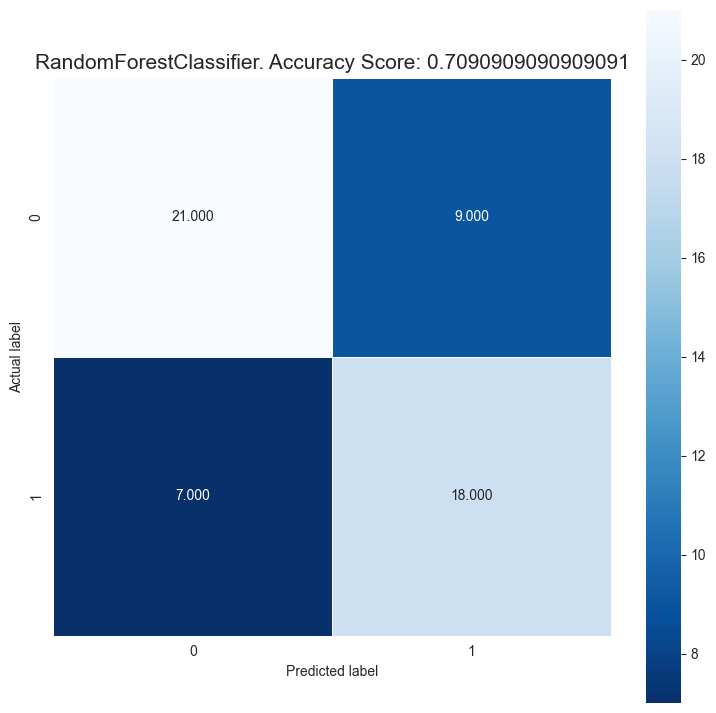

MLPClassifier
>acc=0.691, cfg={'solver': 'lbfgs', 'max_iter': 140, 'hidden_layer_sizes': 186}
Accuracy: 0.691 


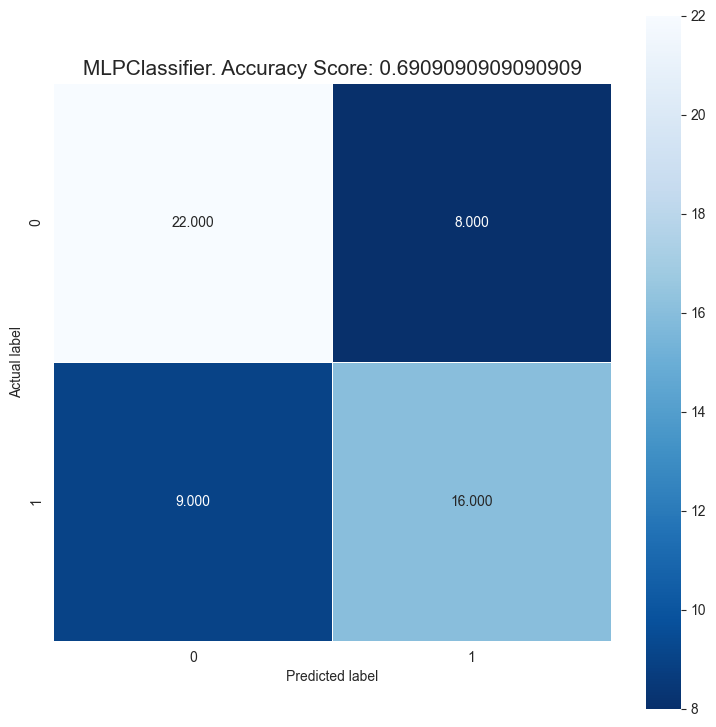

LogisticRegression
>acc=0.582, cfg={'solver': 'saga', 'max_iter': 4, 'C': 3.5354181818181822}
Accuracy: 0.582 


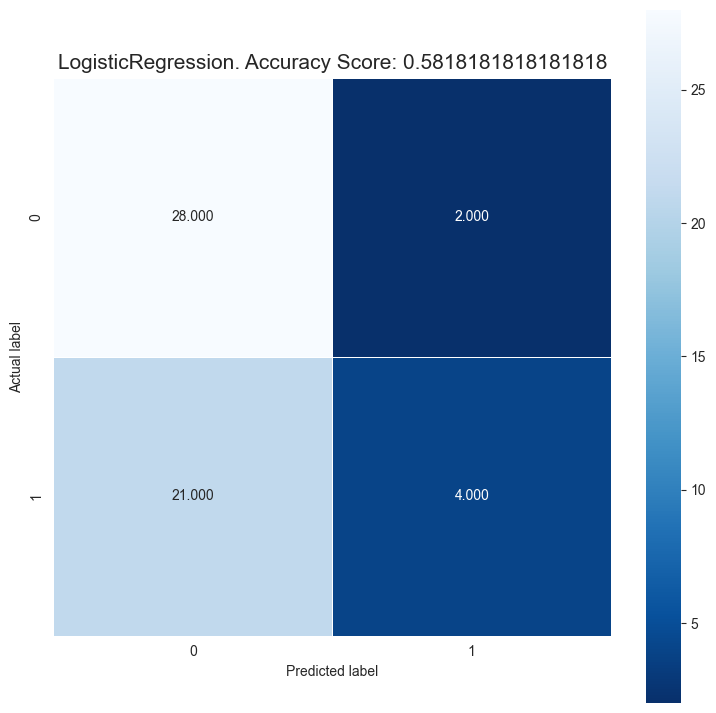

DecisionTreeClassifier
>acc=0.636, cfg={'max_features': 'log2', 'max_depth': 7, 'criterion': 'gini'}
Accuracy: 0.636 


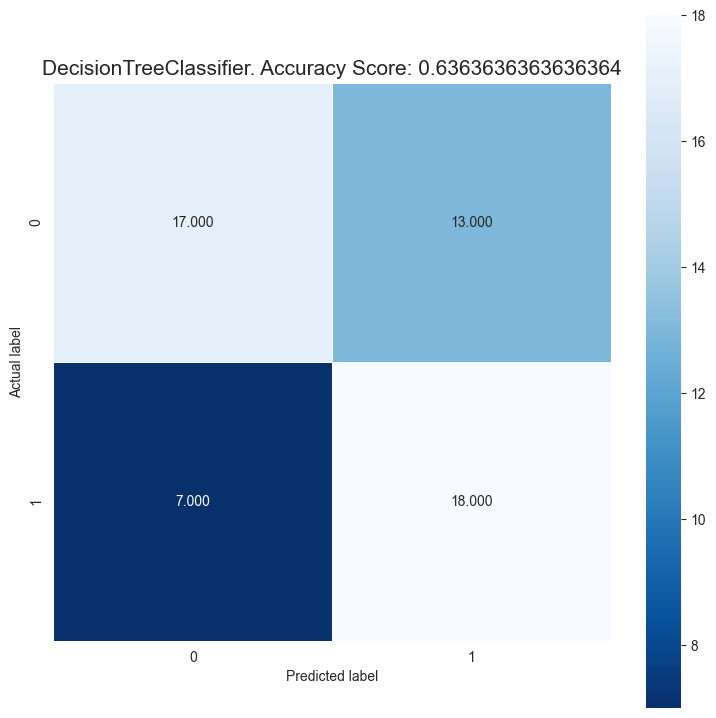

KNeighborsClassifier
>acc=0.673, cfg={'weights': 'uniform', 'n_neighbors': 14, 'algorithm': 'ball_tree'}
Accuracy: 0.673 


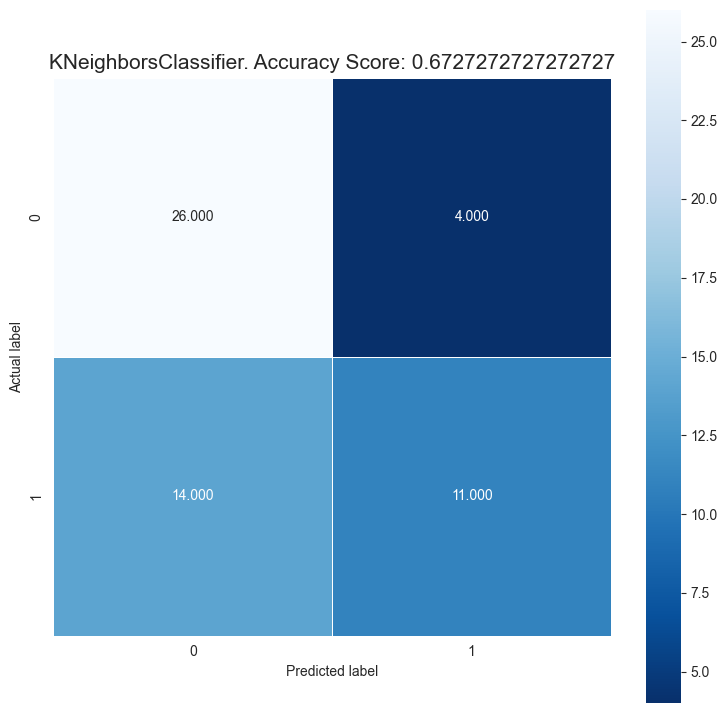

SVC
>acc=0.600, cfg={'kernel': 'poly', 'C': 0.5051454545454546}
Accuracy: 0.600 


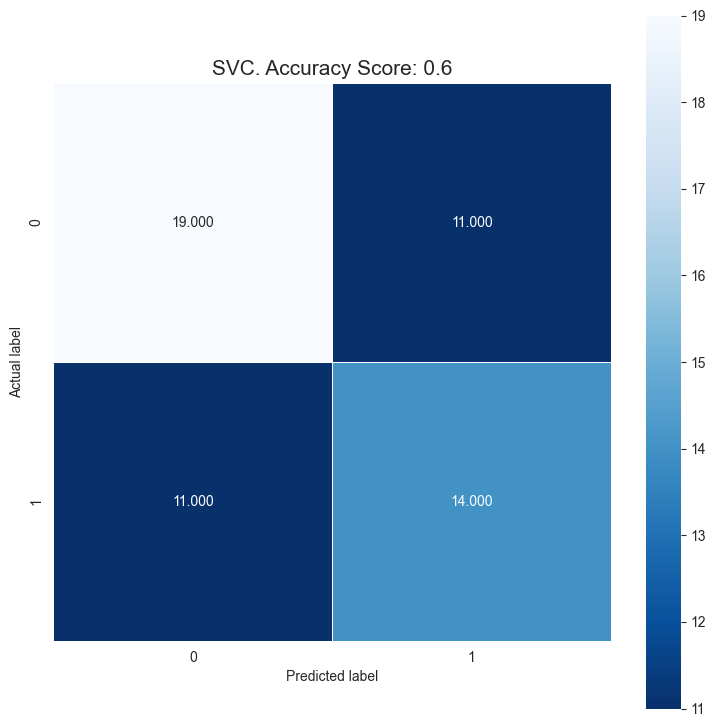

AdaBoostClassifier
>acc=0.564, cfg={'n_estimators': 5, 'learning_rate': 0.778}
Accuracy: 0.564 


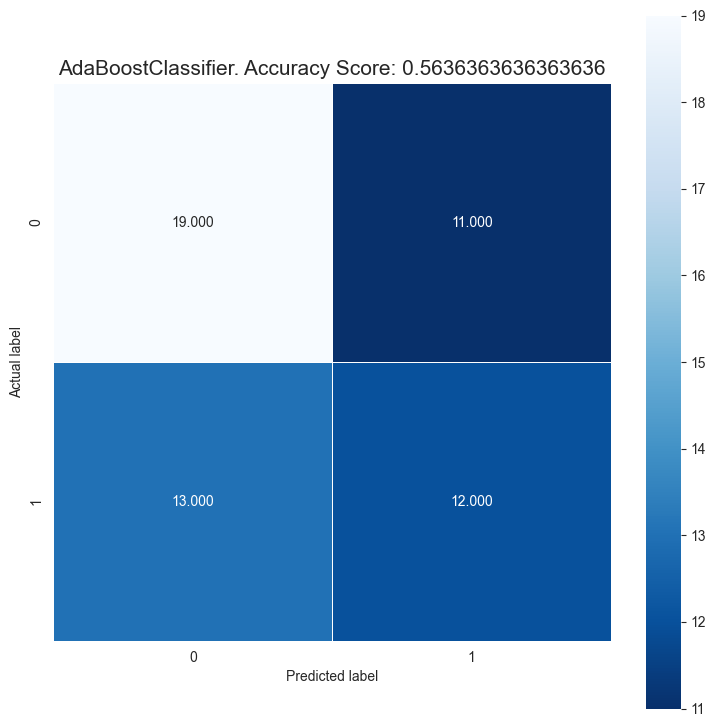

In [16]:
df_report_2 = pd.DataFrame()

df_report_2 = xval_test(reg_RF, space_rf, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_MLP, space_mlp, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_lin, space_lr, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_DT, space_dt, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_KN, space_kn, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_SVC, space_svc, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_adboost, space_adboost, df_report_2, concat_train, train_y, concat_test, test_y)

In [17]:
df_report_2

,Accuracy,F1,Precision,Recall,Balanced Acc,ROC-AUC,params
RandomForestClassifier,0.709091,0.692308,0.666667,0.72,0.710000,0.710000,"{'n_estimators': 1, 'max_features': 12, 'max_d..."
MLPClassifier,0.690909,0.653061,0.666667,0.64,0.686667,0.676000,"{'solver': 'lbfgs', 'max_iter': 140, 'hidden_l..."
LogisticRegression,0.581818,0.258065,0.666667,0.16,0.546667,0.562667,"{'solver': 'saga', 'max_iter': 4, 'C': 3.53541..."
DecisionTreeClassifier,0.636364,0.642857,0.580645,0.72,0.643333,0.600667,"{'max_features': 'log2', 'max_depth': 7, 'crit..."
KNeighborsClassifier,0.672727,0.550000,0.733333,0.44,0.653333,0.670000,"{'weights': 'uniform', 'n_neighbors': 14, 'alg..."
SVC,0.600000,0.560000,0.560000,0.56,0.596667,0.580000,"{'kernel': 'poly', 'C': 0.5051454545454546}"
AdaBoostClassifier,0.563636,0.500000,0.521739,0.48,0.556667,0.554667,"{'n_estimators': 5, 'learning_rate': 0.778}"


0.7090909090909091


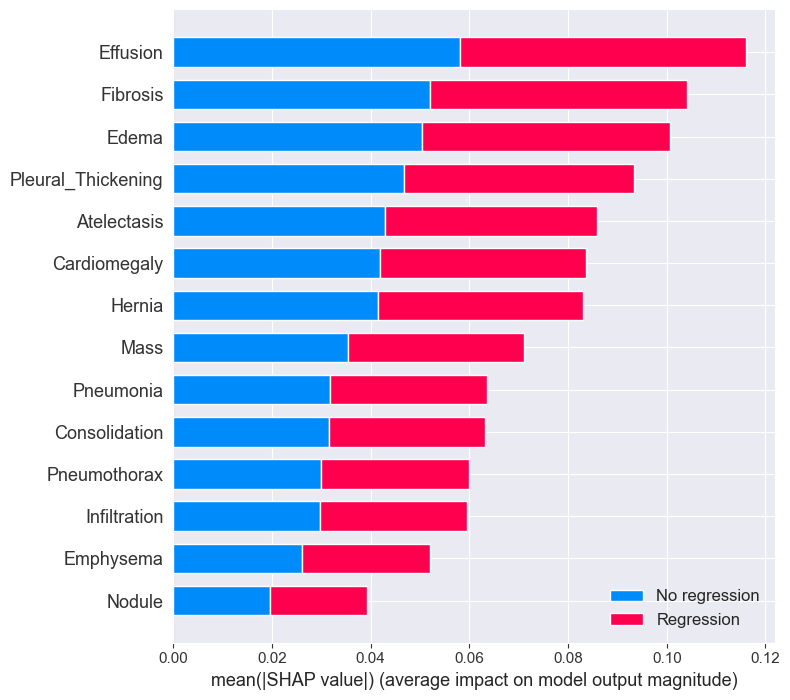

In [18]:
import shap
reg = RandomForestClassifier(random_state=2022, n_estimators=5, max_features=12, max_depth=9, criterion='gini')
reg.fit(concat_train, train_y)

r2_score = reg.score(concat_test, test_y)
print(r2_score)

shap_values = shap.TreeExplainer(reg, ).shap_values(concat_test)
shap.summary_plot(shap_values, concat_train,
                  feature_names=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
                                 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
                                 'Pneumonia', 'Pneumothorax'], class_names=['No regression', 'Regression'], show=False)
plt.savefig('importance_scatter_dt.pdf', format='pdf', dpi=1200, bbox_inches='tight')